In [1]:
!git clone https://github.com/11erlangga/mpdw-kelompok1.git

Cloning into 'mpdw-kelompok1'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 141 (delta 53), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (141/141), 693.16 KiB | 3.63 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.9 MB/s eta 0:00:00


# Import Dependencies

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error

from nbeats_model import NBeatsInterpretableModel
from nbeats_utils import TimeSeriesDataset, EarlyStopping, progression_plot

import optuna
from optuna.exceptions import TrialPruned

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == "train":
    model.train()
    context_manager = torch.enable_grad()
  elif mode == "val":
    model.eval()
    context_manager = torch.inference_mode()

  with context_manager:
    total_cost = 0
    for feature, target in tqdm(dataloader, leave=False, desc=mode.title()):
      feature, target = feature.to(device, non_blocking=True), target.to(device, non_blocking=True)
      outputs = model(feature)
      pred = outputs["forecast_total"]
      loss = criterion(pred, target)

      if mode == "train":
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      total_cost += loss.item() * feature.shape[0]

    avg_cost = total_cost / len(dataset)
    return avg_cost

def forecast_with_rolling_origin(model, train_data, test_data, in_len, device):
  model.eval()

  current_data = train_data.copy().reset_index(drop=True)
  preds, trend_preds, season_preds = [], [], []

  for i in tqdm(range(len(test_data))):
    input_feat = torch.tensor(
        current_data[-in_len:]['y'].values,
        dtype=torch.float32,
        device=device
    ).unsqueeze(0).unsqueeze(-1)

    with torch.inference_mode():
      outputs = model(input_feat)

    preds.append(outputs["forecast_total"].detach().cpu().numpy().ravel()[0])
    trend_preds.append(outputs["forecast_trend"].detach().cpu().numpy().ravel()[0])
    season_preds.append(outputs["forecast_seasonality"].detach().cpu().numpy().ravel()[0])

    actual_row = test_data.iloc[i:i+1].copy().reset_index(drop=True)
    current_data = pd.concat([current_data, actual_row], ignore_index=True)

  return np.array(preds), np.array(trend_preds), np.array(season_preds)

def forecast_with_rolling_origin_with_fine_tune(model, initial_weights, criterion, train_data, test_data, in_len, device):
  current_data = train_data.copy().reset_index(drop=True)
  preds, trend_preds, season_preds = [], [], []

  for i in tqdm(range(len(test_data))):
    if i > 0:
      dataset = TimeSeriesDataset(current_data['y'].values.reshape(-1, 1), in_len, 1)
      dataloader = DataLoader(
          dataset,
          batch_size=64,
          shuffle=False,
          num_workers=os.cpu_count(),
          pin_memory=True
      )

      model.load_state_dict(initial_weights)
      # Freeze semua parameter
      for _, p in model.named_parameters():
        p.requires_grad = False

      # Tentukan block terakhir
      last_trend_block = max(int(n.split('.')[2])
                              for n, _ in model.named_parameters() if n.startswith("trend_stack.blocks"))
      last_season_block = max(int(n.split('.')[2])
                              for n, _ in model.named_parameters() if n.startswith("seasonality_stack.blocks"))

      # Unfreeze forecast_head dan FC block terakhir
      trainable_prefixes = [
          f"trend_stack.blocks.{last_trend_block}.forecast_head",
          f"seasonality_stack.blocks.{last_season_block}.forecast_head",
          f"trend_stack.blocks.{last_trend_block}.fc",
          f"seasonality_stack.blocks.{last_season_block}.fc",
      ]

      for name, p in model.named_parameters():
        if any(name.startswith(pref) for pref in trainable_prefixes):
          p.requires_grad = True

      optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad],
                              lr=1e-4)

      for epoch in range(2):
        _ = loop_fn("train", dataset, dataloader, model, criterion, optimizer, device)

    input_feat = torch.tensor(
        current_data[-in_len:]['y'].values,
        dtype=torch.float32,
        device=device
    ).unsqueeze(0).unsqueeze(-1)

    model.eval()
    with torch.inference_mode():
      outputs = model(input_feat)

    preds.append(outputs["forecast_total"].detach().cpu().numpy().ravel()[0])
    trend_preds.append(outputs["forecast_trend"].detach().cpu().numpy().ravel()[0])
    season_preds.append(outputs["forecast_seasonality"].detach().cpu().numpy().ravel()[0])

    actual_row = test_data.iloc[i:i+1].copy().reset_index(drop=True)
    current_data = pd.concat([current_data, actual_row], ignore_index=True)

  return np.array(preds), np.array(trend_preds), np.array(season_preds)

def mean_absolute_scaled_error(y_true, y_pred):
  n = len(y_true)
  d = np.abs(np.diff(y_true)).sum()/(n-1)
  errors = np.abs(y_true - y_pred)
  return errors.mean()/d

def weighted_absolute_percentage_error(y_true, y_pred):
  return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

# Data Preparation

In [5]:
data = pd.read_csv('/content/mpdw-kelompok1/data/train.csv')
data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', drop=True, inplace=True)
data.drop(columns=['In_Total', 'Total_Total'], inplace=True)
data.rename(columns={'Out_Total': 'y'}, inplace=True)

data

,y
Date,
2023-01-01,41799
2023-01-02,53543
2023-01-03,53846
2023-01-04,55379
2023-01-05,58437
...,...
2023-11-26,51518
2023-11-27,67043
2023-11-28,59229


In [6]:
data_test = pd.read_csv('/content/mpdw-kelompok1/data/test.csv')
data_test['Date'] = pd.to_datetime(data_test['Date'])

data_test.set_index('Date', drop=True, inplace=True)
data_test.drop(columns=['In_Total', 'Total_Total'], inplace=True)
data_test.rename(columns={'Out_Total': 'y'}, inplace=True)

data_test

,y
Date,
2023-12-01,57537
2023-12-02,52733
2023-12-03,45094
2023-12-04,58937
2023-12-05,61772
2023-12-06,51043
2023-12-07,58112
2023-12-08,59532
2023-12-09,49875


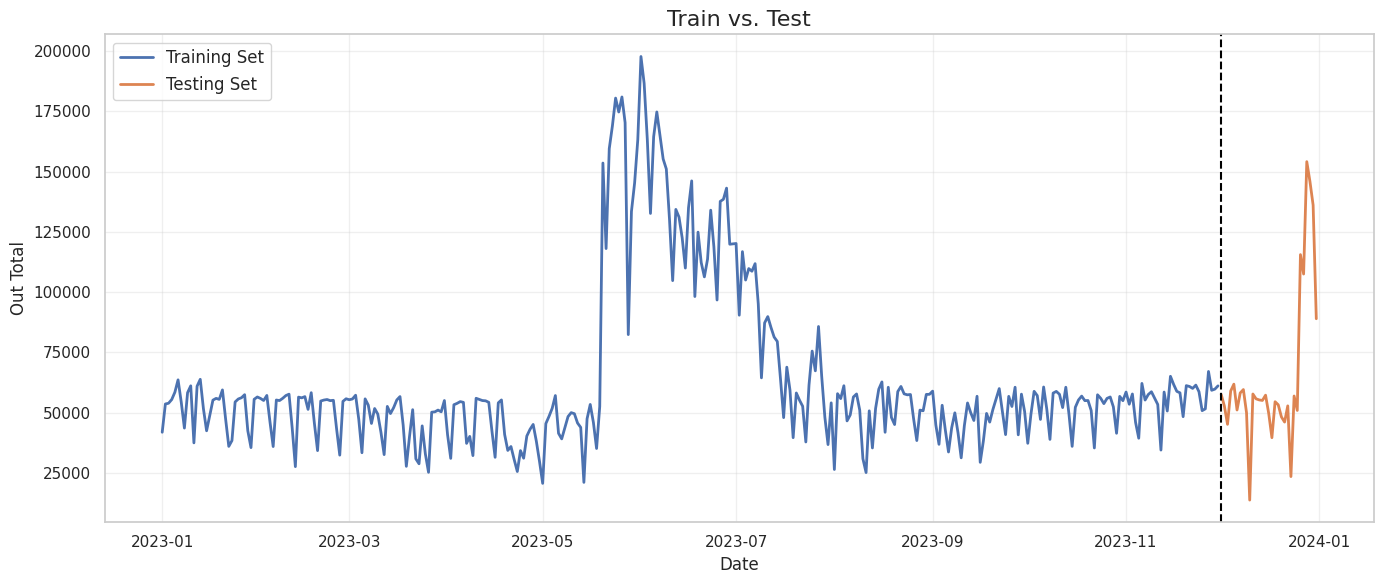

In [7]:
plt.figure(figsize=(14, 6))

# Plot
plt.plot(data['y'], label='Training Set', linewidth=2)
plt.plot(data_test['y'], label='Testing Set', linewidth=2)

plt.axvline(data_test.index.min(), color='black', linestyle='--', linewidth=1.5)

plt.title('Train vs. Test', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Out Total', fontsize=12)

plt.grid(alpha=0.3)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Normalization

In [8]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=['y'])
data_test_scaled = scaler.transform(data_test)
data_test_scaled = pd.DataFrame(data_test_scaled, columns=['y'])

with open("nbeats_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Dataset & Data Loader

In [9]:
BATCH_SIZE = 64
INPUT_LEN = 7
OUTPUT_LEN = 1

train_set = TimeSeriesDataset(data_scaled.values, INPUT_LEN, OUTPUT_LEN)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True, # Shuffle data training
    num_workers=os.cpu_count(),
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")

Train batches: 6


In [10]:
next(iter(train_loader))[0].shape

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([64, 7, 1])

# Training Preparation

In [11]:
TREND_BLOCKS = 1
TREND_HIDDENS = 64
POLY_DEGREE = 3

SEASON_BLOCKS = 1
SEASON_HIDDENS = 512
NUM_FOURIER = 4
SEASONALITY_PERIOD = 7

model = NBeatsInterpretableModel(
    input_len=INPUT_LEN,
    output_len=OUTPUT_LEN,
    trend_blocks=TREND_BLOCKS,
    trend_hiddens=TREND_HIDDENS,
    poly_degree=POLY_DEGREE,
    season_blocks=SEASON_BLOCKS,
    season_hiddens=SEASON_HIDDENS,
    num_fourier=NUM_FOURIER,
    seasonality_period=SEASONALITY_PERIOD
).to(device)

summary(model, (INPUT_LEN, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             512
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 64]           4,160
              ReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 64]           4,160
              ReLU-8                   [-1, 64]               0
            Linear-9                    [-1, 4]             260
           Linear-10                    [-1, 4]             260
      NBeatsBlock-11         [[-1, 7], [-1, 1]]               0
      NBeatsStack-12  [[-1, 7], [-1, 1], [-1, 7]]               0
           Linear-13                  [-1, 512]           4,096
             ReLU-14                 

In [12]:
criterion = nn.HuberLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.002828784585351845, weight_decay=9.011244586707508e-06)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', patience=9, factor=0.1
)

early_stopping = EarlyStopping(
    patience=20, min_delta=1e-5, path="best_model.pt"
)

# Training

In [13]:
train_loss_history = []
epoch_history = []

for epoch in range(1000):
  print(f"\n--- Epoch {epoch} ---")

  train_cost = loop_fn("train", train_set, train_loader, model, criterion, optimizer, device)

  train_loss_history.append(train_cost)
  epoch_history.append(epoch)

  print(f"Epoch {epoch}: "
        f"Train Loss: {train_cost:.6f}")

  scheduler.step(train_cost)
  early_stopping(train_cost, model)

  if early_stopping.early_stop:
    if epoch < 500:
      early_stopping.early_stop = False
      early_stopping.counter = 0
    else:
        print(f"Early stopping triggered")
        break

model.load_state_dict(torch.load("best_model.pt"))


--- Epoch 0 ---


Train:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: Train Loss: 2.657782
Validation loss decreased (2.657782). Saving model ...

--- Epoch 1 ---


Epoch 1: Train Loss: 0.052379
Validation loss decreased (0.052379). Saving model ...

--- Epoch 2 ---


Epoch 2: Train Loss: 0.012932
Validation loss decreased (0.012932). Saving model ...

--- Epoch 3 ---


Epoch 3: Train Loss: 0.025800
EarlyStopping counter: 1 out of 20

--- Epoch 4 ---


Epoch 4: Train Loss: 0.017530
EarlyStopping counter: 2 out of 20

--- Epoch 5 ---


Epoch 5: Train Loss: 0.007200
Validation loss decreased (0.007200). Saving model ...

--- Epoch 6 ---


Epoch 6: Train Loss: 0.007174
Validation loss decreased (0.007174). Saving model ...

--- Epoch 7 ---


Epoch 7: Train Loss: 0.004710
Validation loss decreased (0.004710). Saving model ...

--- Epoch 8 ---


Epoch 8: Train Loss: 0.003759
Validation loss decreased (0.003759). Saving model ...

--- Epoch 9 ---


Epoch 9: Train Loss: 0.004208
EarlyStopping counter: 1 out of 20

--- Epoch 10 ---


Epoch 10: Train Loss: 0.003749
EarlyStopping counter: 2 out of 20

--- Epoch 11 ---


Epoch 11: Train Loss: 0.003102
Validation loss decreased (0.003102). Saving model ...

--- Epoch 12 ---


Epoch 12: Train Loss: 0.002848
Validation loss decreased (0.002848). Saving model ...

--- Epoch 13 ---


Epoch 13: Train Loss: 0.002498
Validation loss decreased (0.002498). Saving model ...

--- Epoch 14 ---


Epoch 14: Train Loss: 0.002450
Validation loss decreased (0.002450). Saving model ...

--- Epoch 15 ---


Epoch 15: Train Loss: 0.002400
Validation loss decreased (0.002400). Saving model ...

--- Epoch 16 ---


Epoch 16: Train Loss: 0.002535
EarlyStopping counter: 1 out of 20

--- Epoch 17 ---


Epoch 17: Train Loss: 0.002509
EarlyStopping counter: 2 out of 20

--- Epoch 18 ---


Epoch 18: Train Loss: 0.002312
Validation loss decreased (0.002312). Saving model ...

--- Epoch 19 ---


Epoch 19: Train Loss: 0.002179
Validation loss decreased (0.002179). Saving model ...

--- Epoch 20 ---


Epoch 20: Train Loss: 0.002046
Validation loss decreased (0.002046). Saving model ...

--- Epoch 21 ---


Epoch 21: Train Loss: 0.002270
EarlyStopping counter: 1 out of 20

--- Epoch 22 ---


Epoch 22: Train Loss: 0.002121
EarlyStopping counter: 2 out of 20

--- Epoch 23 ---


Epoch 23: Train Loss: 0.002187
EarlyStopping counter: 3 out of 20

--- Epoch 24 ---


Epoch 24: Train Loss: 0.002047
EarlyStopping counter: 4 out of 20

--- Epoch 25 ---


Epoch 25: Train Loss: 0.002224
EarlyStopping counter: 5 out of 20

--- Epoch 26 ---


Epoch 26: Train Loss: 0.001817
Validation loss decreased (0.001817). Saving model ...

--- Epoch 27 ---


Epoch 27: Train Loss: 0.001841
EarlyStopping counter: 1 out of 20

--- Epoch 28 ---


Epoch 28: Train Loss: 0.002022
EarlyStopping counter: 2 out of 20

--- Epoch 29 ---


Epoch 29: Train Loss: 0.002265
EarlyStopping counter: 3 out of 20

--- Epoch 30 ---


Epoch 30: Train Loss: 0.002584
EarlyStopping counter: 4 out of 20

--- Epoch 31 ---


Epoch 31: Train Loss: 0.002444
EarlyStopping counter: 5 out of 20

--- Epoch 32 ---


Epoch 32: Train Loss: 0.002646
EarlyStopping counter: 6 out of 20

--- Epoch 33 ---


Epoch 33: Train Loss: 0.001998
EarlyStopping counter: 7 out of 20

--- Epoch 34 ---


Epoch 34: Train Loss: 0.001881
EarlyStopping counter: 8 out of 20

--- Epoch 35 ---


Epoch 35: Train Loss: 0.001923
EarlyStopping counter: 9 out of 20

--- Epoch 36 ---


Epoch 36: Train Loss: 0.002064
EarlyStopping counter: 10 out of 20

--- Epoch 37 ---


Epoch 37: Train Loss: 0.002108
EarlyStopping counter: 11 out of 20

--- Epoch 38 ---


Epoch 38: Train Loss: 0.001551
Validation loss decreased (0.001551). Saving model ...

--- Epoch 39 ---


Epoch 39: Train Loss: 0.001551
EarlyStopping counter: 1 out of 20

--- Epoch 40 ---


Epoch 40: Train Loss: 0.001547
EarlyStopping counter: 2 out of 20

--- Epoch 41 ---


Epoch 41: Train Loss: 0.001472
Validation loss decreased (0.001472). Saving model ...

--- Epoch 42 ---


Epoch 42: Train Loss: 0.001469
EarlyStopping counter: 1 out of 20

--- Epoch 43 ---


Epoch 43: Train Loss: 0.001459
Validation loss decreased (0.001459). Saving model ...

--- Epoch 44 ---


Epoch 44: Train Loss: 0.001433
Validation loss decreased (0.001433). Saving model ...

--- Epoch 45 ---


Epoch 45: Train Loss: 0.001464
EarlyStopping counter: 1 out of 20

--- Epoch 46 ---


Epoch 46: Train Loss: 0.001451
EarlyStopping counter: 2 out of 20

--- Epoch 47 ---


Epoch 47: Train Loss: 0.001416
Validation loss decreased (0.001416). Saving model ...

--- Epoch 48 ---


Epoch 48: Train Loss: 0.001412
EarlyStopping counter: 1 out of 20

--- Epoch 49 ---


Epoch 49: Train Loss: 0.001397
Validation loss decreased (0.001397). Saving model ...

--- Epoch 50 ---


Epoch 50: Train Loss: 0.001395
EarlyStopping counter: 1 out of 20

--- Epoch 51 ---


Epoch 51: Train Loss: 0.001389
EarlyStopping counter: 2 out of 20

--- Epoch 52 ---


Epoch 52: Train Loss: 0.001375
Validation loss decreased (0.001375). Saving model ...

--- Epoch 53 ---


Epoch 53: Train Loss: 0.001367
EarlyStopping counter: 1 out of 20

--- Epoch 54 ---


Epoch 54: Train Loss: 0.001365
EarlyStopping counter: 2 out of 20

--- Epoch 55 ---


Epoch 55: Train Loss: 0.001353
Validation loss decreased (0.001353). Saving model ...

--- Epoch 56 ---


Epoch 56: Train Loss: 0.001349
EarlyStopping counter: 1 out of 20

--- Epoch 57 ---


Epoch 57: Train Loss: 0.001361
EarlyStopping counter: 2 out of 20

--- Epoch 58 ---


Epoch 58: Train Loss: 0.001349
EarlyStopping counter: 3 out of 20

--- Epoch 59 ---


Epoch 59: Train Loss: 0.001342
Validation loss decreased (0.001342). Saving model ...

--- Epoch 60 ---


Epoch 60: Train Loss: 0.001326
Validation loss decreased (0.001326). Saving model ...

--- Epoch 61 ---


Epoch 61: Train Loss: 0.001321
EarlyStopping counter: 1 out of 20

--- Epoch 62 ---


Epoch 62: Train Loss: 0.001314
Validation loss decreased (0.001314). Saving model ...

--- Epoch 63 ---


Epoch 63: Train Loss: 0.001303
Validation loss decreased (0.001303). Saving model ...

--- Epoch 64 ---


Epoch 64: Train Loss: 0.001297
EarlyStopping counter: 1 out of 20

--- Epoch 65 ---


Epoch 65: Train Loss: 0.001306
EarlyStopping counter: 2 out of 20

--- Epoch 66 ---


Epoch 66: Train Loss: 0.001307
EarlyStopping counter: 3 out of 20

--- Epoch 67 ---


Epoch 67: Train Loss: 0.001346
EarlyStopping counter: 4 out of 20

--- Epoch 68 ---


Epoch 68: Train Loss: 0.001348
EarlyStopping counter: 5 out of 20

--- Epoch 69 ---


Epoch 69: Train Loss: 0.001329
EarlyStopping counter: 6 out of 20

--- Epoch 70 ---


Epoch 70: Train Loss: 0.001299
EarlyStopping counter: 7 out of 20

--- Epoch 71 ---


Epoch 71: Train Loss: 0.001291
Validation loss decreased (0.001291). Saving model ...

--- Epoch 72 ---


Epoch 72: Train Loss: 0.001279
Validation loss decreased (0.001279). Saving model ...

--- Epoch 73 ---


Epoch 73: Train Loss: 0.001247
Validation loss decreased (0.001247). Saving model ...

--- Epoch 74 ---


Epoch 74: Train Loss: 0.001261
EarlyStopping counter: 1 out of 20

--- Epoch 75 ---


Epoch 75: Train Loss: 0.001247
EarlyStopping counter: 2 out of 20

--- Epoch 76 ---


Epoch 76: Train Loss: 0.001231
Validation loss decreased (0.001231). Saving model ...

--- Epoch 77 ---


Epoch 77: Train Loss: 0.001221
EarlyStopping counter: 1 out of 20

--- Epoch 78 ---


Epoch 78: Train Loss: 0.001239
EarlyStopping counter: 2 out of 20

--- Epoch 79 ---


Epoch 79: Train Loss: 0.001218
Validation loss decreased (0.001218). Saving model ...

--- Epoch 80 ---


Epoch 80: Train Loss: 0.001206
Validation loss decreased (0.001206). Saving model ...

--- Epoch 81 ---


Epoch 81: Train Loss: 0.001200
EarlyStopping counter: 1 out of 20

--- Epoch 82 ---


Epoch 82: Train Loss: 0.001192
Validation loss decreased (0.001192). Saving model ...

--- Epoch 83 ---


Epoch 83: Train Loss: 0.001187
EarlyStopping counter: 1 out of 20

--- Epoch 84 ---


Epoch 84: Train Loss: 0.001189
EarlyStopping counter: 2 out of 20

--- Epoch 85 ---


Epoch 85: Train Loss: 0.001180
Validation loss decreased (0.001180). Saving model ...

--- Epoch 86 ---


Epoch 86: Train Loss: 0.001174
EarlyStopping counter: 1 out of 20

--- Epoch 87 ---


Epoch 87: Train Loss: 0.001172
EarlyStopping counter: 2 out of 20

--- Epoch 88 ---


Epoch 88: Train Loss: 0.001166
Validation loss decreased (0.001166). Saving model ...

--- Epoch 89 ---


Epoch 89: Train Loss: 0.001172
EarlyStopping counter: 1 out of 20

--- Epoch 90 ---


Epoch 90: Train Loss: 0.001151
Validation loss decreased (0.001151). Saving model ...

--- Epoch 91 ---


Epoch 91: Train Loss: 0.001145
EarlyStopping counter: 1 out of 20

--- Epoch 92 ---


Epoch 92: Train Loss: 0.001138
Validation loss decreased (0.001138). Saving model ...

--- Epoch 93 ---


Epoch 93: Train Loss: 0.001129
EarlyStopping counter: 1 out of 20

--- Epoch 94 ---


Epoch 94: Train Loss: 0.001128
EarlyStopping counter: 2 out of 20

--- Epoch 95 ---


Epoch 95: Train Loss: 0.001118
Validation loss decreased (0.001118). Saving model ...

--- Epoch 96 ---


Epoch 96: Train Loss: 0.001116
EarlyStopping counter: 1 out of 20

--- Epoch 97 ---


Epoch 97: Train Loss: 0.001119
EarlyStopping counter: 2 out of 20

--- Epoch 98 ---


Epoch 98: Train Loss: 0.001102
Validation loss decreased (0.001102). Saving model ...

--- Epoch 99 ---


Epoch 99: Train Loss: 0.001104
EarlyStopping counter: 1 out of 20

--- Epoch 100 ---


Epoch 100: Train Loss: 0.001106
EarlyStopping counter: 2 out of 20

--- Epoch 101 ---


Epoch 101: Train Loss: 0.001091
Validation loss decreased (0.001091). Saving model ...

--- Epoch 102 ---


Epoch 102: Train Loss: 0.001090
EarlyStopping counter: 1 out of 20

--- Epoch 103 ---


Epoch 103: Train Loss: 0.001075
Validation loss decreased (0.001075). Saving model ...

--- Epoch 104 ---


Epoch 104: Train Loss: 0.001090
EarlyStopping counter: 1 out of 20

--- Epoch 105 ---


Epoch 105: Train Loss: 0.001075
EarlyStopping counter: 2 out of 20

--- Epoch 106 ---


Epoch 106: Train Loss: 0.001089
EarlyStopping counter: 3 out of 20

--- Epoch 107 ---


Epoch 107: Train Loss: 0.001088
EarlyStopping counter: 4 out of 20

--- Epoch 108 ---


Epoch 108: Train Loss: 0.001061
Validation loss decreased (0.001061). Saving model ...

--- Epoch 109 ---


Epoch 109: Train Loss: 0.001048
Validation loss decreased (0.001048). Saving model ...

--- Epoch 110 ---


Epoch 110: Train Loss: 0.001040
EarlyStopping counter: 1 out of 20

--- Epoch 111 ---


Epoch 111: Train Loss: 0.001025
Validation loss decreased (0.001025). Saving model ...

--- Epoch 112 ---


Epoch 112: Train Loss: 0.001034
EarlyStopping counter: 1 out of 20

--- Epoch 113 ---


Epoch 113: Train Loss: 0.001016
EarlyStopping counter: 2 out of 20

--- Epoch 114 ---


Epoch 114: Train Loss: 0.001021
EarlyStopping counter: 3 out of 20

--- Epoch 115 ---


Epoch 115: Train Loss: 0.001002
Validation loss decreased (0.001002). Saving model ...

--- Epoch 116 ---


Epoch 116: Train Loss: 0.001005
EarlyStopping counter: 1 out of 20

--- Epoch 117 ---


Epoch 117: Train Loss: 0.001002
EarlyStopping counter: 2 out of 20

--- Epoch 118 ---


Epoch 118: Train Loss: 0.000979
Validation loss decreased (0.000979). Saving model ...

--- Epoch 119 ---


Epoch 119: Train Loss: 0.000987
EarlyStopping counter: 1 out of 20

--- Epoch 120 ---


Epoch 120: Train Loss: 0.000969
Validation loss decreased (0.000969). Saving model ...

--- Epoch 121 ---


Epoch 121: Train Loss: 0.000958
Validation loss decreased (0.000958). Saving model ...

--- Epoch 122 ---


Epoch 122: Train Loss: 0.000992
EarlyStopping counter: 1 out of 20

--- Epoch 123 ---


Epoch 123: Train Loss: 0.000972
EarlyStopping counter: 2 out of 20

--- Epoch 124 ---


Epoch 124: Train Loss: 0.000957
EarlyStopping counter: 3 out of 20

--- Epoch 125 ---


Epoch 125: Train Loss: 0.000943
Validation loss decreased (0.000943). Saving model ...

--- Epoch 126 ---


Epoch 126: Train Loss: 0.000981
EarlyStopping counter: 1 out of 20

--- Epoch 127 ---


Epoch 127: Train Loss: 0.000956
EarlyStopping counter: 2 out of 20

--- Epoch 128 ---


Epoch 128: Train Loss: 0.000935
EarlyStopping counter: 3 out of 20

--- Epoch 129 ---


Epoch 129: Train Loss: 0.000924
Validation loss decreased (0.000924). Saving model ...

--- Epoch 130 ---


Epoch 130: Train Loss: 0.000914
Validation loss decreased (0.000914). Saving model ...

--- Epoch 131 ---


Epoch 131: Train Loss: 0.000940
EarlyStopping counter: 1 out of 20

--- Epoch 132 ---


Epoch 132: Train Loss: 0.000939
EarlyStopping counter: 2 out of 20

--- Epoch 133 ---


Epoch 133: Train Loss: 0.000923
EarlyStopping counter: 3 out of 20

--- Epoch 134 ---


Epoch 134: Train Loss: 0.000906
EarlyStopping counter: 4 out of 20

--- Epoch 135 ---


Epoch 135: Train Loss: 0.000895
Validation loss decreased (0.000895). Saving model ...

--- Epoch 136 ---


Epoch 136: Train Loss: 0.000884
Validation loss decreased (0.000884). Saving model ...

--- Epoch 137 ---


Epoch 137: Train Loss: 0.000870
Validation loss decreased (0.000870). Saving model ...

--- Epoch 138 ---


Epoch 138: Train Loss: 0.000861
EarlyStopping counter: 1 out of 20

--- Epoch 139 ---


Epoch 139: Train Loss: 0.000880
EarlyStopping counter: 2 out of 20

--- Epoch 140 ---


Epoch 140: Train Loss: 0.000880
EarlyStopping counter: 3 out of 20

--- Epoch 141 ---


Epoch 141: Train Loss: 0.000883
EarlyStopping counter: 4 out of 20

--- Epoch 142 ---


Epoch 142: Train Loss: 0.000894
EarlyStopping counter: 5 out of 20

--- Epoch 143 ---


Epoch 143: Train Loss: 0.000875
EarlyStopping counter: 6 out of 20

--- Epoch 144 ---


Epoch 144: Train Loss: 0.000847
Validation loss decreased (0.000847). Saving model ...

--- Epoch 145 ---


Epoch 145: Train Loss: 0.000850
EarlyStopping counter: 1 out of 20

--- Epoch 146 ---


Epoch 146: Train Loss: 0.000819
Validation loss decreased (0.000819). Saving model ...

--- Epoch 147 ---


Epoch 147: Train Loss: 0.000828
EarlyStopping counter: 1 out of 20

--- Epoch 148 ---


Epoch 148: Train Loss: 0.000809
Validation loss decreased (0.000809). Saving model ...

--- Epoch 149 ---


Epoch 149: Train Loss: 0.000796
Validation loss decreased (0.000796). Saving model ...

--- Epoch 150 ---


Epoch 150: Train Loss: 0.000788
EarlyStopping counter: 1 out of 20

--- Epoch 151 ---


Epoch 151: Train Loss: 0.000778
Validation loss decreased (0.000778). Saving model ...

--- Epoch 152 ---


Epoch 152: Train Loss: 0.000778
EarlyStopping counter: 1 out of 20

--- Epoch 153 ---


Epoch 153: Train Loss: 0.000952
EarlyStopping counter: 2 out of 20

--- Epoch 154 ---


Epoch 154: Train Loss: 0.000885
EarlyStopping counter: 3 out of 20

--- Epoch 155 ---


Epoch 155: Train Loss: 0.000827
EarlyStopping counter: 4 out of 20

--- Epoch 156 ---


Epoch 156: Train Loss: 0.000829
EarlyStopping counter: 5 out of 20

--- Epoch 157 ---


Epoch 157: Train Loss: 0.000825
EarlyStopping counter: 6 out of 20

--- Epoch 158 ---


Epoch 158: Train Loss: 0.000768
Validation loss decreased (0.000768). Saving model ...

--- Epoch 159 ---


Epoch 159: Train Loss: 0.000773
EarlyStopping counter: 1 out of 20

--- Epoch 160 ---


Epoch 160: Train Loss: 0.000735
Validation loss decreased (0.000735). Saving model ...

--- Epoch 161 ---


Epoch 161: Train Loss: 0.000745
EarlyStopping counter: 1 out of 20

--- Epoch 162 ---


Epoch 162: Train Loss: 0.000722
Validation loss decreased (0.000722). Saving model ...

--- Epoch 163 ---


Epoch 163: Train Loss: 0.000722
EarlyStopping counter: 1 out of 20

--- Epoch 164 ---


Epoch 164: Train Loss: 0.000703
Validation loss decreased (0.000703). Saving model ...

--- Epoch 165 ---


Epoch 165: Train Loss: 0.000691
Validation loss decreased (0.000691). Saving model ...

--- Epoch 166 ---


Epoch 166: Train Loss: 0.000683
EarlyStopping counter: 1 out of 20

--- Epoch 167 ---


Epoch 167: Train Loss: 0.000731
EarlyStopping counter: 2 out of 20

--- Epoch 168 ---


Epoch 168: Train Loss: 0.000712
EarlyStopping counter: 3 out of 20

--- Epoch 169 ---


Epoch 169: Train Loss: 0.000711
EarlyStopping counter: 4 out of 20

--- Epoch 170 ---


Epoch 170: Train Loss: 0.000707
EarlyStopping counter: 5 out of 20

--- Epoch 171 ---


Epoch 171: Train Loss: 0.000710
EarlyStopping counter: 6 out of 20

--- Epoch 172 ---


Epoch 172: Train Loss: 0.000672
Validation loss decreased (0.000672). Saving model ...

--- Epoch 173 ---


Epoch 173: Train Loss: 0.000663
EarlyStopping counter: 1 out of 20

--- Epoch 174 ---


Epoch 174: Train Loss: 0.000663
EarlyStopping counter: 2 out of 20

--- Epoch 175 ---


Epoch 175: Train Loss: 0.000637
Validation loss decreased (0.000637). Saving model ...

--- Epoch 176 ---


Epoch 176: Train Loss: 0.000642
EarlyStopping counter: 1 out of 20

--- Epoch 177 ---


Epoch 177: Train Loss: 0.000631
EarlyStopping counter: 2 out of 20

--- Epoch 178 ---


Epoch 178: Train Loss: 0.000626
Validation loss decreased (0.000626). Saving model ...

--- Epoch 179 ---


Epoch 179: Train Loss: 0.000627
EarlyStopping counter: 1 out of 20

--- Epoch 180 ---


Epoch 180: Train Loss: 0.000611
Validation loss decreased (0.000611). Saving model ...

--- Epoch 181 ---


Epoch 181: Train Loss: 0.000634
EarlyStopping counter: 1 out of 20

--- Epoch 182 ---


Epoch 182: Train Loss: 0.000628
EarlyStopping counter: 2 out of 20

--- Epoch 183 ---


Epoch 183: Train Loss: 0.000630
EarlyStopping counter: 3 out of 20

--- Epoch 184 ---


Epoch 184: Train Loss: 0.000621
EarlyStopping counter: 4 out of 20

--- Epoch 185 ---


Epoch 185: Train Loss: 0.000588
Validation loss decreased (0.000588). Saving model ...

--- Epoch 186 ---


Epoch 186: Train Loss: 0.000643
EarlyStopping counter: 1 out of 20

--- Epoch 187 ---


Epoch 187: Train Loss: 0.000633
EarlyStopping counter: 2 out of 20

--- Epoch 188 ---


Epoch 188: Train Loss: 0.000639
EarlyStopping counter: 3 out of 20

--- Epoch 189 ---


Epoch 189: Train Loss: 0.000628
EarlyStopping counter: 4 out of 20

--- Epoch 190 ---


Epoch 190: Train Loss: 0.000562
Validation loss decreased (0.000562). Saving model ...

--- Epoch 191 ---


Epoch 191: Train Loss: 0.000574
EarlyStopping counter: 1 out of 20

--- Epoch 192 ---


Epoch 192: Train Loss: 0.000588
EarlyStopping counter: 2 out of 20

--- Epoch 193 ---


Epoch 193: Train Loss: 0.000562
EarlyStopping counter: 3 out of 20

--- Epoch 194 ---


Epoch 194: Train Loss: 0.000552
Validation loss decreased (0.000552). Saving model ...

--- Epoch 195 ---


Epoch 195: Train Loss: 0.000538
Validation loss decreased (0.000538). Saving model ...

--- Epoch 196 ---


Epoch 196: Train Loss: 0.000528
Validation loss decreased (0.000528). Saving model ...

--- Epoch 197 ---


Epoch 197: Train Loss: 0.000534
EarlyStopping counter: 1 out of 20

--- Epoch 198 ---


Epoch 198: Train Loss: 0.000529
EarlyStopping counter: 2 out of 20

--- Epoch 199 ---


Epoch 199: Train Loss: 0.000519
EarlyStopping counter: 3 out of 20

--- Epoch 200 ---


Epoch 200: Train Loss: 0.000612
EarlyStopping counter: 4 out of 20

--- Epoch 201 ---


Epoch 201: Train Loss: 0.000635
EarlyStopping counter: 5 out of 20

--- Epoch 202 ---


Epoch 202: Train Loss: 0.000614
EarlyStopping counter: 6 out of 20

--- Epoch 203 ---


Epoch 203: Train Loss: 0.000593
EarlyStopping counter: 7 out of 20

--- Epoch 204 ---


Epoch 204: Train Loss: 0.000544
EarlyStopping counter: 8 out of 20

--- Epoch 205 ---


Epoch 205: Train Loss: 0.000519
EarlyStopping counter: 9 out of 20

--- Epoch 206 ---


Epoch 206: Train Loss: 0.000513
Validation loss decreased (0.000513). Saving model ...

--- Epoch 207 ---


Epoch 207: Train Loss: 0.000493
Validation loss decreased (0.000493). Saving model ...

--- Epoch 208 ---


Epoch 208: Train Loss: 0.000485
EarlyStopping counter: 1 out of 20

--- Epoch 209 ---


Epoch 209: Train Loss: 0.000482
Validation loss decreased (0.000482). Saving model ...

--- Epoch 210 ---


Epoch 210: Train Loss: 0.000575
EarlyStopping counter: 1 out of 20

--- Epoch 211 ---


Epoch 211: Train Loss: 0.000570
EarlyStopping counter: 2 out of 20

--- Epoch 212 ---


Epoch 212: Train Loss: 0.000505
EarlyStopping counter: 3 out of 20

--- Epoch 213 ---


Epoch 213: Train Loss: 0.000600
EarlyStopping counter: 4 out of 20

--- Epoch 214 ---


Epoch 214: Train Loss: 0.000491
EarlyStopping counter: 5 out of 20

--- Epoch 215 ---


Epoch 215: Train Loss: 0.000508
EarlyStopping counter: 6 out of 20

--- Epoch 216 ---


Epoch 216: Train Loss: 0.000493
EarlyStopping counter: 7 out of 20

--- Epoch 217 ---


Epoch 217: Train Loss: 0.000457
Validation loss decreased (0.000457). Saving model ...

--- Epoch 218 ---


Epoch 218: Train Loss: 0.000472
EarlyStopping counter: 1 out of 20

--- Epoch 219 ---


Epoch 219: Train Loss: 0.000455
EarlyStopping counter: 2 out of 20

--- Epoch 220 ---


Epoch 220: Train Loss: 0.000459
EarlyStopping counter: 3 out of 20

--- Epoch 221 ---


Epoch 221: Train Loss: 0.000477
EarlyStopping counter: 4 out of 20

--- Epoch 222 ---


Epoch 222: Train Loss: 0.000447
Validation loss decreased (0.000447). Saving model ...

--- Epoch 223 ---


Epoch 223: Train Loss: 0.000426
Validation loss decreased (0.000426). Saving model ...

--- Epoch 224 ---


Epoch 224: Train Loss: 0.000414
Validation loss decreased (0.000414). Saving model ...

--- Epoch 225 ---


Epoch 225: Train Loss: 0.000433
EarlyStopping counter: 1 out of 20

--- Epoch 226 ---


Epoch 226: Train Loss: 0.000405
EarlyStopping counter: 2 out of 20

--- Epoch 227 ---


Epoch 227: Train Loss: 0.000409
EarlyStopping counter: 3 out of 20

--- Epoch 228 ---


Epoch 228: Train Loss: 0.000409
EarlyStopping counter: 4 out of 20

--- Epoch 229 ---


Epoch 229: Train Loss: 0.000391
Validation loss decreased (0.000391). Saving model ...

--- Epoch 230 ---


Epoch 230: Train Loss: 0.000377
Validation loss decreased (0.000377). Saving model ...

--- Epoch 231 ---


Epoch 231: Train Loss: 0.000396
EarlyStopping counter: 1 out of 20

--- Epoch 232 ---


Epoch 232: Train Loss: 0.000422
EarlyStopping counter: 2 out of 20

--- Epoch 233 ---


Epoch 233: Train Loss: 0.000395
EarlyStopping counter: 3 out of 20

--- Epoch 234 ---


Epoch 234: Train Loss: 0.000398
EarlyStopping counter: 4 out of 20

--- Epoch 235 ---


Epoch 235: Train Loss: 0.000388
EarlyStopping counter: 5 out of 20

--- Epoch 236 ---


Epoch 236: Train Loss: 0.000421
EarlyStopping counter: 6 out of 20

--- Epoch 237 ---


Epoch 237: Train Loss: 0.000434
EarlyStopping counter: 7 out of 20

--- Epoch 238 ---


Epoch 238: Train Loss: 0.000408
EarlyStopping counter: 8 out of 20

--- Epoch 239 ---


Epoch 239: Train Loss: 0.000405
EarlyStopping counter: 9 out of 20

--- Epoch 240 ---


Epoch 240: Train Loss: 0.000385
EarlyStopping counter: 10 out of 20

--- Epoch 241 ---


Epoch 241: Train Loss: 0.000365
Validation loss decreased (0.000365). Saving model ...

--- Epoch 242 ---


Epoch 242: Train Loss: 0.000352
Validation loss decreased (0.000352). Saving model ...

--- Epoch 243 ---


Epoch 243: Train Loss: 0.000346
EarlyStopping counter: 1 out of 20

--- Epoch 244 ---


Epoch 244: Train Loss: 0.000345
EarlyStopping counter: 2 out of 20

--- Epoch 245 ---


Epoch 245: Train Loss: 0.000342
Validation loss decreased (0.000342). Saving model ...

--- Epoch 246 ---


Epoch 246: Train Loss: 0.000341
EarlyStopping counter: 1 out of 20

--- Epoch 247 ---


Epoch 247: Train Loss: 0.000342
EarlyStopping counter: 2 out of 20

--- Epoch 248 ---


Epoch 248: Train Loss: 0.000337
EarlyStopping counter: 3 out of 20

--- Epoch 249 ---


Epoch 249: Train Loss: 0.000334
EarlyStopping counter: 4 out of 20

--- Epoch 250 ---


Epoch 250: Train Loss: 0.000333
EarlyStopping counter: 5 out of 20

--- Epoch 251 ---


Epoch 251: Train Loss: 0.000332
EarlyStopping counter: 6 out of 20

--- Epoch 252 ---


Epoch 252: Train Loss: 0.000332
Validation loss decreased (0.000332). Saving model ...

--- Epoch 253 ---


Epoch 253: Train Loss: 0.000330
EarlyStopping counter: 1 out of 20

--- Epoch 254 ---


Epoch 254: Train Loss: 0.000330
EarlyStopping counter: 2 out of 20

--- Epoch 255 ---


Epoch 255: Train Loss: 0.000329
EarlyStopping counter: 3 out of 20

--- Epoch 256 ---


Epoch 256: Train Loss: 0.000328
EarlyStopping counter: 4 out of 20

--- Epoch 257 ---


Epoch 257: Train Loss: 0.000327
EarlyStopping counter: 5 out of 20

--- Epoch 258 ---


Epoch 258: Train Loss: 0.000327
EarlyStopping counter: 6 out of 20

--- Epoch 259 ---


Epoch 259: Train Loss: 0.000326
EarlyStopping counter: 7 out of 20

--- Epoch 260 ---


Epoch 260: Train Loss: 0.000326
EarlyStopping counter: 8 out of 20

--- Epoch 261 ---


Epoch 261: Train Loss: 0.000325
EarlyStopping counter: 9 out of 20

--- Epoch 262 ---


Epoch 262: Train Loss: 0.000325
EarlyStopping counter: 10 out of 20

--- Epoch 263 ---


Epoch 263: Train Loss: 0.000324
EarlyStopping counter: 11 out of 20

--- Epoch 264 ---


Epoch 264: Train Loss: 0.000324
EarlyStopping counter: 12 out of 20

--- Epoch 265 ---


Epoch 265: Train Loss: 0.000324
EarlyStopping counter: 13 out of 20

--- Epoch 266 ---


Epoch 266: Train Loss: 0.000323
EarlyStopping counter: 14 out of 20

--- Epoch 267 ---


Epoch 267: Train Loss: 0.000322
EarlyStopping counter: 15 out of 20

--- Epoch 268 ---


Epoch 268: Train Loss: 0.000322
EarlyStopping counter: 16 out of 20

--- Epoch 269 ---


Epoch 269: Train Loss: 0.000322
EarlyStopping counter: 17 out of 20

--- Epoch 270 ---


Epoch 270: Train Loss: 0.000321
Validation loss decreased (0.000321). Saving model ...

--- Epoch 271 ---


Epoch 271: Train Loss: 0.000320
EarlyStopping counter: 1 out of 20

--- Epoch 272 ---


Epoch 272: Train Loss: 0.000320
EarlyStopping counter: 2 out of 20

--- Epoch 273 ---


Epoch 273: Train Loss: 0.000319
EarlyStopping counter: 3 out of 20

--- Epoch 274 ---


Epoch 274: Train Loss: 0.000319
EarlyStopping counter: 4 out of 20

--- Epoch 275 ---


Epoch 275: Train Loss: 0.000319
EarlyStopping counter: 5 out of 20

--- Epoch 276 ---


Epoch 276: Train Loss: 0.000321
EarlyStopping counter: 6 out of 20

--- Epoch 277 ---


Epoch 277: Train Loss: 0.000320
EarlyStopping counter: 7 out of 20

--- Epoch 278 ---


Epoch 278: Train Loss: 0.000318
EarlyStopping counter: 8 out of 20

--- Epoch 279 ---


Epoch 279: Train Loss: 0.000318
EarlyStopping counter: 9 out of 20

--- Epoch 280 ---


Epoch 280: Train Loss: 0.000318
EarlyStopping counter: 10 out of 20

--- Epoch 281 ---


Epoch 281: Train Loss: 0.000317
EarlyStopping counter: 11 out of 20

--- Epoch 282 ---


Epoch 282: Train Loss: 0.000318
EarlyStopping counter: 12 out of 20

--- Epoch 283 ---


Epoch 283: Train Loss: 0.000316
EarlyStopping counter: 13 out of 20

--- Epoch 284 ---


Epoch 284: Train Loss: 0.000315
EarlyStopping counter: 14 out of 20

--- Epoch 285 ---


Epoch 285: Train Loss: 0.000315
EarlyStopping counter: 15 out of 20

--- Epoch 286 ---


Epoch 286: Train Loss: 0.000315
EarlyStopping counter: 16 out of 20

--- Epoch 287 ---


Epoch 287: Train Loss: 0.000315
EarlyStopping counter: 17 out of 20

--- Epoch 288 ---


Epoch 288: Train Loss: 0.000313
EarlyStopping counter: 18 out of 20

--- Epoch 289 ---


Epoch 289: Train Loss: 0.000314
EarlyStopping counter: 19 out of 20

--- Epoch 290 ---


Epoch 290: Train Loss: 0.000315
EarlyStopping counter: 20 out of 20

--- Epoch 291 ---


Epoch 291: Train Loss: 0.000320
EarlyStopping counter: 1 out of 20

--- Epoch 292 ---


Epoch 292: Train Loss: 0.000320
EarlyStopping counter: 2 out of 20

--- Epoch 293 ---


Epoch 293: Train Loss: 0.000320
EarlyStopping counter: 3 out of 20

--- Epoch 294 ---


Epoch 294: Train Loss: 0.000320
EarlyStopping counter: 4 out of 20

--- Epoch 295 ---


Epoch 295: Train Loss: 0.000319
EarlyStopping counter: 5 out of 20

--- Epoch 296 ---


Epoch 296: Train Loss: 0.000319
EarlyStopping counter: 6 out of 20

--- Epoch 297 ---


Epoch 297: Train Loss: 0.000319
EarlyStopping counter: 7 out of 20

--- Epoch 298 ---


Epoch 298: Train Loss: 0.000318
EarlyStopping counter: 8 out of 20

--- Epoch 299 ---


Epoch 299: Train Loss: 0.000317
EarlyStopping counter: 9 out of 20

--- Epoch 300 ---


Epoch 300: Train Loss: 0.000317
EarlyStopping counter: 10 out of 20

--- Epoch 301 ---


Epoch 301: Train Loss: 0.000317
EarlyStopping counter: 11 out of 20

--- Epoch 302 ---


Epoch 302: Train Loss: 0.000317
EarlyStopping counter: 12 out of 20

--- Epoch 303 ---


Epoch 303: Train Loss: 0.000317
EarlyStopping counter: 13 out of 20

--- Epoch 304 ---


Epoch 304: Train Loss: 0.000317
EarlyStopping counter: 14 out of 20

--- Epoch 305 ---


Epoch 305: Train Loss: 0.000317
EarlyStopping counter: 15 out of 20

--- Epoch 306 ---


Epoch 306: Train Loss: 0.000317
EarlyStopping counter: 16 out of 20

--- Epoch 307 ---


Epoch 307: Train Loss: 0.000316
EarlyStopping counter: 17 out of 20

--- Epoch 308 ---


Epoch 308: Train Loss: 0.000316
EarlyStopping counter: 18 out of 20

--- Epoch 309 ---


Epoch 309: Train Loss: 0.000316
EarlyStopping counter: 19 out of 20

--- Epoch 310 ---


Epoch 310: Train Loss: 0.000316
EarlyStopping counter: 20 out of 20

--- Epoch 311 ---


Epoch 311: Train Loss: 0.000320
EarlyStopping counter: 1 out of 20

--- Epoch 312 ---


Epoch 312: Train Loss: 0.000320
EarlyStopping counter: 2 out of 20

--- Epoch 313 ---


Epoch 313: Train Loss: 0.000320
EarlyStopping counter: 3 out of 20

--- Epoch 314 ---


Epoch 314: Train Loss: 0.000320
EarlyStopping counter: 4 out of 20

--- Epoch 315 ---


Epoch 315: Train Loss: 0.000320
EarlyStopping counter: 5 out of 20

--- Epoch 316 ---


Epoch 316: Train Loss: 0.000320
EarlyStopping counter: 6 out of 20

--- Epoch 317 ---


Epoch 317: Train Loss: 0.000320
EarlyStopping counter: 7 out of 20

--- Epoch 318 ---


Epoch 318: Train Loss: 0.000320
EarlyStopping counter: 8 out of 20

--- Epoch 319 ---


Epoch 319: Train Loss: 0.000320
EarlyStopping counter: 9 out of 20

--- Epoch 320 ---


Epoch 320: Train Loss: 0.000320
EarlyStopping counter: 10 out of 20

--- Epoch 321 ---


Epoch 321: Train Loss: 0.000320
EarlyStopping counter: 11 out of 20

--- Epoch 322 ---


Epoch 322: Train Loss: 0.000320
EarlyStopping counter: 12 out of 20

--- Epoch 323 ---


Epoch 323: Train Loss: 0.000320
EarlyStopping counter: 13 out of 20

--- Epoch 324 ---


Epoch 324: Train Loss: 0.000320
EarlyStopping counter: 14 out of 20

--- Epoch 325 ---


Epoch 325: Train Loss: 0.000320
EarlyStopping counter: 15 out of 20

--- Epoch 326 ---


Epoch 326: Train Loss: 0.000320
EarlyStopping counter: 16 out of 20

--- Epoch 327 ---


Epoch 327: Train Loss: 0.000320
EarlyStopping counter: 17 out of 20

--- Epoch 328 ---


Epoch 328: Train Loss: 0.000320
EarlyStopping counter: 18 out of 20

--- Epoch 329 ---


Epoch 329: Train Loss: 0.000320
EarlyStopping counter: 19 out of 20

--- Epoch 330 ---


Epoch 330: Train Loss: 0.000320
EarlyStopping counter: 20 out of 20

--- Epoch 331 ---


Epoch 331: Train Loss: 0.000320
EarlyStopping counter: 1 out of 20

--- Epoch 332 ---


Epoch 332: Train Loss: 0.000320
EarlyStopping counter: 2 out of 20

--- Epoch 333 ---


Epoch 333: Train Loss: 0.000320
EarlyStopping counter: 3 out of 20

--- Epoch 334 ---


Epoch 334: Train Loss: 0.000320
EarlyStopping counter: 4 out of 20

--- Epoch 335 ---


Epoch 335: Train Loss: 0.000320
EarlyStopping counter: 5 out of 20

--- Epoch 336 ---


Epoch 336: Train Loss: 0.000320
EarlyStopping counter: 6 out of 20

--- Epoch 337 ---


Epoch 337: Train Loss: 0.000320
EarlyStopping counter: 7 out of 20

--- Epoch 338 ---


Epoch 338: Train Loss: 0.000320
EarlyStopping counter: 8 out of 20

--- Epoch 339 ---


Epoch 339: Train Loss: 0.000320
EarlyStopping counter: 9 out of 20

--- Epoch 340 ---


Epoch 340: Train Loss: 0.000320
EarlyStopping counter: 10 out of 20

--- Epoch 341 ---


Epoch 341: Train Loss: 0.000320
EarlyStopping counter: 11 out of 20

--- Epoch 342 ---


Epoch 342: Train Loss: 0.000320
EarlyStopping counter: 12 out of 20

--- Epoch 343 ---


Epoch 343: Train Loss: 0.000320
EarlyStopping counter: 13 out of 20

--- Epoch 344 ---


Epoch 344: Train Loss: 0.000320
EarlyStopping counter: 14 out of 20

--- Epoch 345 ---


Epoch 345: Train Loss: 0.000320
EarlyStopping counter: 15 out of 20

--- Epoch 346 ---


Epoch 346: Train Loss: 0.000320
EarlyStopping counter: 16 out of 20

--- Epoch 347 ---


Epoch 347: Train Loss: 0.000320
EarlyStopping counter: 17 out of 20

--- Epoch 348 ---


Epoch 348: Train Loss: 0.000320
EarlyStopping counter: 18 out of 20

--- Epoch 349 ---


Epoch 349: Train Loss: 0.000320
EarlyStopping counter: 19 out of 20

--- Epoch 350 ---


Epoch 350: Train Loss: 0.000320
EarlyStopping counter: 20 out of 20

--- Epoch 351 ---


Epoch 351: Train Loss: 0.000320
EarlyStopping counter: 1 out of 20

--- Epoch 352 ---


Epoch 352: Train Loss: 0.000320
EarlyStopping counter: 2 out of 20

--- Epoch 353 ---


Epoch 353: Train Loss: 0.000320
EarlyStopping counter: 3 out of 20

--- Epoch 354 ---


Epoch 354: Train Loss: 0.000320
EarlyStopping counter: 4 out of 20

--- Epoch 355 ---


Epoch 355: Train Loss: 0.000320
EarlyStopping counter: 5 out of 20

--- Epoch 356 ---


Epoch 356: Train Loss: 0.000320
EarlyStopping counter: 6 out of 20

--- Epoch 357 ---


Epoch 357: Train Loss: 0.000320
EarlyStopping counter: 7 out of 20

--- Epoch 358 ---


Epoch 358: Train Loss: 0.000320
EarlyStopping counter: 8 out of 20

--- Epoch 359 ---


Epoch 359: Train Loss: 0.000320
EarlyStopping counter: 9 out of 20

--- Epoch 360 ---


Epoch 360: Train Loss: 0.000320
EarlyStopping counter: 10 out of 20

--- Epoch 361 ---


Epoch 361: Train Loss: 0.000320
EarlyStopping counter: 11 out of 20

--- Epoch 362 ---


Epoch 362: Train Loss: 0.000320
EarlyStopping counter: 12 out of 20

--- Epoch 363 ---


Epoch 363: Train Loss: 0.000320
EarlyStopping counter: 13 out of 20

--- Epoch 364 ---


Epoch 364: Train Loss: 0.000320
EarlyStopping counter: 14 out of 20

--- Epoch 365 ---


Epoch 365: Train Loss: 0.000320
EarlyStopping counter: 15 out of 20

--- Epoch 366 ---


Epoch 366: Train Loss: 0.000320
EarlyStopping counter: 16 out of 20

--- Epoch 367 ---


Epoch 367: Train Loss: 0.000320
EarlyStopping counter: 17 out of 20

--- Epoch 368 ---


Epoch 368: Train Loss: 0.000320
EarlyStopping counter: 18 out of 20

--- Epoch 369 ---


Epoch 369: Train Loss: 0.000320
EarlyStopping counter: 19 out of 20

--- Epoch 370 ---


Epoch 370: Train Loss: 0.000320
EarlyStopping counter: 20 out of 20

--- Epoch 371 ---


Epoch 371: Train Loss: 0.000320
EarlyStopping counter: 1 out of 20

--- Epoch 372 ---


Epoch 372: Train Loss: 0.000320
EarlyStopping counter: 2 out of 20

--- Epoch 373 ---


Epoch 373: Train Loss: 0.000320
EarlyStopping counter: 3 out of 20

--- Epoch 374 ---


Epoch 374: Train Loss: 0.000320
EarlyStopping counter: 4 out of 20

--- Epoch 375 ---


Epoch 375: Train Loss: 0.000320
EarlyStopping counter: 5 out of 20

--- Epoch 376 ---


Epoch 376: Train Loss: 0.000320
EarlyStopping counter: 6 out of 20

--- Epoch 377 ---


Epoch 377: Train Loss: 0.000320
EarlyStopping counter: 7 out of 20

--- Epoch 378 ---


Epoch 378: Train Loss: 0.000320
EarlyStopping counter: 8 out of 20

--- Epoch 379 ---


Epoch 379: Train Loss: 0.000320
EarlyStopping counter: 9 out of 20

--- Epoch 380 ---


Epoch 380: Train Loss: 0.000320
EarlyStopping counter: 10 out of 20

--- Epoch 381 ---


Epoch 381: Train Loss: 0.000320
EarlyStopping counter: 11 out of 20

--- Epoch 382 ---


Epoch 382: Train Loss: 0.000320
EarlyStopping counter: 12 out of 20

--- Epoch 383 ---


Epoch 383: Train Loss: 0.000320
EarlyStopping counter: 13 out of 20

--- Epoch 384 ---


Epoch 384: Train Loss: 0.000320
EarlyStopping counter: 14 out of 20

--- Epoch 385 ---


Epoch 385: Train Loss: 0.000320
EarlyStopping counter: 15 out of 20

--- Epoch 386 ---


Epoch 386: Train Loss: 0.000320
EarlyStopping counter: 16 out of 20

--- Epoch 387 ---


Epoch 387: Train Loss: 0.000320
EarlyStopping counter: 17 out of 20

--- Epoch 388 ---


Epoch 388: Train Loss: 0.000320
EarlyStopping counter: 18 out of 20

--- Epoch 389 ---


Epoch 389: Train Loss: 0.000320
EarlyStopping counter: 19 out of 20

--- Epoch 390 ---


Epoch 390: Train Loss: 0.000320
EarlyStopping counter: 20 out of 20

--- Epoch 391 ---


Epoch 391: Train Loss: 0.000320
EarlyStopping counter: 1 out of 20

--- Epoch 392 ---


Epoch 392: Train Loss: 0.000320
EarlyStopping counter: 2 out of 20

--- Epoch 393 ---


Epoch 393: Train Loss: 0.000320
EarlyStopping counter: 3 out of 20

--- Epoch 394 ---


Epoch 394: Train Loss: 0.000320
EarlyStopping counter: 4 out of 20

--- Epoch 395 ---


Epoch 395: Train Loss: 0.000320
EarlyStopping counter: 5 out of 20

--- Epoch 396 ---


Epoch 396: Train Loss: 0.000320
EarlyStopping counter: 6 out of 20

--- Epoch 397 ---


Epoch 397: Train Loss: 0.000320
EarlyStopping counter: 7 out of 20

--- Epoch 398 ---


Epoch 398: Train Loss: 0.000320
EarlyStopping counter: 8 out of 20

--- Epoch 399 ---


Epoch 399: Train Loss: 0.000320
EarlyStopping counter: 9 out of 20

--- Epoch 400 ---


Epoch 400: Train Loss: 0.000320
EarlyStopping counter: 10 out of 20

--- Epoch 401 ---


Epoch 401: Train Loss: 0.000320
EarlyStopping counter: 11 out of 20

--- Epoch 402 ---


Epoch 402: Train Loss: 0.000320
EarlyStopping counter: 12 out of 20

--- Epoch 403 ---


Epoch 403: Train Loss: 0.000320
EarlyStopping counter: 13 out of 20

--- Epoch 404 ---


Epoch 404: Train Loss: 0.000320
EarlyStopping counter: 14 out of 20

--- Epoch 405 ---


Epoch 405: Train Loss: 0.000320
EarlyStopping counter: 15 out of 20

--- Epoch 406 ---


Epoch 406: Train Loss: 0.000320
EarlyStopping counter: 16 out of 20

--- Epoch 407 ---


Epoch 407: Train Loss: 0.000320
EarlyStopping counter: 17 out of 20

--- Epoch 408 ---


Epoch 408: Train Loss: 0.000320
EarlyStopping counter: 18 out of 20

--- Epoch 409 ---


Epoch 409: Train Loss: 0.000320
EarlyStopping counter: 19 out of 20

--- Epoch 410 ---


Epoch 410: Train Loss: 0.000320
EarlyStopping counter: 20 out of 20

--- Epoch 411 ---


Epoch 411: Train Loss: 0.000320
EarlyStopping counter: 1 out of 20

--- Epoch 412 ---


Epoch 412: Train Loss: 0.000320
EarlyStopping counter: 2 out of 20

--- Epoch 413 ---


Epoch 413: Train Loss: 0.000320
EarlyStopping counter: 3 out of 20

--- Epoch 414 ---


Epoch 414: Train Loss: 0.000320
EarlyStopping counter: 4 out of 20

--- Epoch 415 ---


Epoch 415: Train Loss: 0.000320
EarlyStopping counter: 5 out of 20

--- Epoch 416 ---


Epoch 416: Train Loss: 0.000320
EarlyStopping counter: 6 out of 20

--- Epoch 417 ---


Epoch 417: Train Loss: 0.000320
EarlyStopping counter: 7 out of 20

--- Epoch 418 ---


Epoch 418: Train Loss: 0.000320
EarlyStopping counter: 8 out of 20

--- Epoch 419 ---


Epoch 419: Train Loss: 0.000320
EarlyStopping counter: 9 out of 20

--- Epoch 420 ---


Epoch 420: Train Loss: 0.000320
EarlyStopping counter: 10 out of 20

--- Epoch 421 ---


Epoch 421: Train Loss: 0.000320
EarlyStopping counter: 11 out of 20

--- Epoch 422 ---


Epoch 422: Train Loss: 0.000320
EarlyStopping counter: 12 out of 20

--- Epoch 423 ---


Epoch 423: Train Loss: 0.000320
EarlyStopping counter: 13 out of 20

--- Epoch 424 ---


Epoch 424: Train Loss: 0.000320
EarlyStopping counter: 14 out of 20

--- Epoch 425 ---


Epoch 425: Train Loss: 0.000320
EarlyStopping counter: 15 out of 20

--- Epoch 426 ---


Epoch 426: Train Loss: 0.000320
EarlyStopping counter: 16 out of 20

--- Epoch 427 ---


Epoch 427: Train Loss: 0.000320
EarlyStopping counter: 17 out of 20

--- Epoch 428 ---


Epoch 428: Train Loss: 0.000320
EarlyStopping counter: 18 out of 20

--- Epoch 429 ---


Epoch 429: Train Loss: 0.000320
EarlyStopping counter: 19 out of 20

--- Epoch 430 ---


Epoch 430: Train Loss: 0.000320
EarlyStopping counter: 20 out of 20

--- Epoch 431 ---


Epoch 431: Train Loss: 0.000320
EarlyStopping counter: 1 out of 20

--- Epoch 432 ---


Epoch 432: Train Loss: 0.000320
EarlyStopping counter: 2 out of 20

--- Epoch 433 ---


Epoch 433: Train Loss: 0.000320
EarlyStopping counter: 3 out of 20

--- Epoch 434 ---


Epoch 434: Train Loss: 0.000320
EarlyStopping counter: 4 out of 20

--- Epoch 435 ---


Epoch 435: Train Loss: 0.000320
EarlyStopping counter: 5 out of 20

--- Epoch 436 ---


Epoch 436: Train Loss: 0.000320
EarlyStopping counter: 6 out of 20

--- Epoch 437 ---


Epoch 437: Train Loss: 0.000320
EarlyStopping counter: 7 out of 20

--- Epoch 438 ---


Epoch 438: Train Loss: 0.000320
EarlyStopping counter: 8 out of 20

--- Epoch 439 ---


Epoch 439: Train Loss: 0.000320
EarlyStopping counter: 9 out of 20

--- Epoch 440 ---


Epoch 440: Train Loss: 0.000320
EarlyStopping counter: 10 out of 20

--- Epoch 441 ---


Epoch 441: Train Loss: 0.000320
EarlyStopping counter: 11 out of 20

--- Epoch 442 ---


Epoch 442: Train Loss: 0.000320
EarlyStopping counter: 12 out of 20

--- Epoch 443 ---


Epoch 443: Train Loss: 0.000320
EarlyStopping counter: 13 out of 20

--- Epoch 444 ---


Epoch 444: Train Loss: 0.000320
EarlyStopping counter: 14 out of 20

--- Epoch 445 ---


Epoch 445: Train Loss: 0.000320
EarlyStopping counter: 15 out of 20

--- Epoch 446 ---


Epoch 446: Train Loss: 0.000320
EarlyStopping counter: 16 out of 20

--- Epoch 447 ---


Epoch 447: Train Loss: 0.000320
EarlyStopping counter: 17 out of 20

--- Epoch 448 ---


Epoch 448: Train Loss: 0.000320
EarlyStopping counter: 18 out of 20

--- Epoch 449 ---


Epoch 449: Train Loss: 0.000320
EarlyStopping counter: 19 out of 20

--- Epoch 450 ---


Epoch 450: Train Loss: 0.000320
EarlyStopping counter: 20 out of 20

--- Epoch 451 ---


Epoch 451: Train Loss: 0.000320
EarlyStopping counter: 1 out of 20

--- Epoch 452 ---


Epoch 452: Train Loss: 0.000320
EarlyStopping counter: 2 out of 20

--- Epoch 453 ---


Epoch 453: Train Loss: 0.000320
EarlyStopping counter: 3 out of 20

--- Epoch 454 ---


Epoch 454: Train Loss: 0.000320
EarlyStopping counter: 4 out of 20

--- Epoch 455 ---


Epoch 455: Train Loss: 0.000320
EarlyStopping counter: 5 out of 20

--- Epoch 456 ---


Epoch 456: Train Loss: 0.000320
EarlyStopping counter: 6 out of 20

--- Epoch 457 ---


Epoch 457: Train Loss: 0.000320
EarlyStopping counter: 7 out of 20

--- Epoch 458 ---


Epoch 458: Train Loss: 0.000320
EarlyStopping counter: 8 out of 20

--- Epoch 459 ---


Epoch 459: Train Loss: 0.000320
EarlyStopping counter: 9 out of 20

--- Epoch 460 ---


Epoch 460: Train Loss: 0.000320
EarlyStopping counter: 10 out of 20

--- Epoch 461 ---


Epoch 461: Train Loss: 0.000320
EarlyStopping counter: 11 out of 20

--- Epoch 462 ---


Epoch 462: Train Loss: 0.000320
EarlyStopping counter: 12 out of 20

--- Epoch 463 ---


Epoch 463: Train Loss: 0.000320
EarlyStopping counter: 13 out of 20

--- Epoch 464 ---


Epoch 464: Train Loss: 0.000320
EarlyStopping counter: 14 out of 20

--- Epoch 465 ---


Epoch 465: Train Loss: 0.000320
EarlyStopping counter: 15 out of 20

--- Epoch 466 ---


Epoch 466: Train Loss: 0.000320
EarlyStopping counter: 16 out of 20

--- Epoch 467 ---


Epoch 467: Train Loss: 0.000320
EarlyStopping counter: 17 out of 20

--- Epoch 468 ---


Epoch 468: Train Loss: 0.000320
EarlyStopping counter: 18 out of 20

--- Epoch 469 ---


Epoch 469: Train Loss: 0.000320
EarlyStopping counter: 19 out of 20

--- Epoch 470 ---


Epoch 470: Train Loss: 0.000320
EarlyStopping counter: 20 out of 20

--- Epoch 471 ---


Epoch 471: Train Loss: 0.000320
EarlyStopping counter: 1 out of 20

--- Epoch 472 ---


Epoch 472: Train Loss: 0.000320
EarlyStopping counter: 2 out of 20

--- Epoch 473 ---


Epoch 473: Train Loss: 0.000320
EarlyStopping counter: 3 out of 20

--- Epoch 474 ---


Epoch 474: Train Loss: 0.000320
EarlyStopping counter: 4 out of 20

--- Epoch 475 ---


Epoch 475: Train Loss: 0.000320
EarlyStopping counter: 5 out of 20

--- Epoch 476 ---


Epoch 476: Train Loss: 0.000320
EarlyStopping counter: 6 out of 20

--- Epoch 477 ---


Epoch 477: Train Loss: 0.000320
EarlyStopping counter: 7 out of 20

--- Epoch 478 ---


Epoch 478: Train Loss: 0.000320
EarlyStopping counter: 8 out of 20

--- Epoch 479 ---


Epoch 479: Train Loss: 0.000320
EarlyStopping counter: 9 out of 20

--- Epoch 480 ---


Epoch 480: Train Loss: 0.000320
EarlyStopping counter: 10 out of 20

--- Epoch 481 ---


Epoch 481: Train Loss: 0.000320
EarlyStopping counter: 11 out of 20

--- Epoch 482 ---


Epoch 482: Train Loss: 0.000320
EarlyStopping counter: 12 out of 20

--- Epoch 483 ---


Epoch 483: Train Loss: 0.000320
EarlyStopping counter: 13 out of 20

--- Epoch 484 ---


Epoch 484: Train Loss: 0.000320
EarlyStopping counter: 14 out of 20

--- Epoch 485 ---


Epoch 485: Train Loss: 0.000320
EarlyStopping counter: 15 out of 20

--- Epoch 486 ---


Epoch 486: Train Loss: 0.000320
EarlyStopping counter: 16 out of 20

--- Epoch 487 ---


Epoch 487: Train Loss: 0.000320
EarlyStopping counter: 17 out of 20

--- Epoch 488 ---


Epoch 488: Train Loss: 0.000320
EarlyStopping counter: 18 out of 20

--- Epoch 489 ---


Epoch 489: Train Loss: 0.000320
EarlyStopping counter: 19 out of 20

--- Epoch 490 ---


Epoch 490: Train Loss: 0.000320
EarlyStopping counter: 20 out of 20

--- Epoch 491 ---


Epoch 491: Train Loss: 0.000320
EarlyStopping counter: 1 out of 20

--- Epoch 492 ---


Epoch 492: Train Loss: 0.000320
EarlyStopping counter: 2 out of 20

--- Epoch 493 ---


Epoch 493: Train Loss: 0.000320
EarlyStopping counter: 3 out of 20

--- Epoch 494 ---


Epoch 494: Train Loss: 0.000320
EarlyStopping counter: 4 out of 20

--- Epoch 495 ---


Epoch 495: Train Loss: 0.000320
EarlyStopping counter: 5 out of 20

--- Epoch 496 ---


Epoch 496: Train Loss: 0.000320
EarlyStopping counter: 6 out of 20

--- Epoch 497 ---


Epoch 497: Train Loss: 0.000320
EarlyStopping counter: 7 out of 20

--- Epoch 498 ---


Epoch 498: Train Loss: 0.000320
EarlyStopping counter: 8 out of 20

--- Epoch 499 ---


Epoch 499: Train Loss: 0.000320
EarlyStopping counter: 9 out of 20

--- Epoch 500 ---


Epoch 500: Train Loss: 0.000320
EarlyStopping counter: 10 out of 20

--- Epoch 501 ---


Epoch 501: Train Loss: 0.000320
EarlyStopping counter: 11 out of 20

--- Epoch 502 ---


Epoch 502: Train Loss: 0.000320
EarlyStopping counter: 12 out of 20

--- Epoch 503 ---


Epoch 503: Train Loss: 0.000320
EarlyStopping counter: 13 out of 20

--- Epoch 504 ---


Epoch 504: Train Loss: 0.000320
EarlyStopping counter: 14 out of 20

--- Epoch 505 ---


Epoch 505: Train Loss: 0.000320
EarlyStopping counter: 15 out of 20

--- Epoch 506 ---


Epoch 506: Train Loss: 0.000320
EarlyStopping counter: 16 out of 20

--- Epoch 507 ---


Epoch 507: Train Loss: 0.000320
EarlyStopping counter: 17 out of 20

--- Epoch 508 ---


Epoch 508: Train Loss: 0.000320
EarlyStopping counter: 18 out of 20

--- Epoch 509 ---


Epoch 509: Train Loss: 0.000320
EarlyStopping counter: 19 out of 20

--- Epoch 510 ---


Epoch 510: Train Loss: 0.000320
EarlyStopping counter: 20 out of 20
Early stopping triggered


<All keys matched successfully>

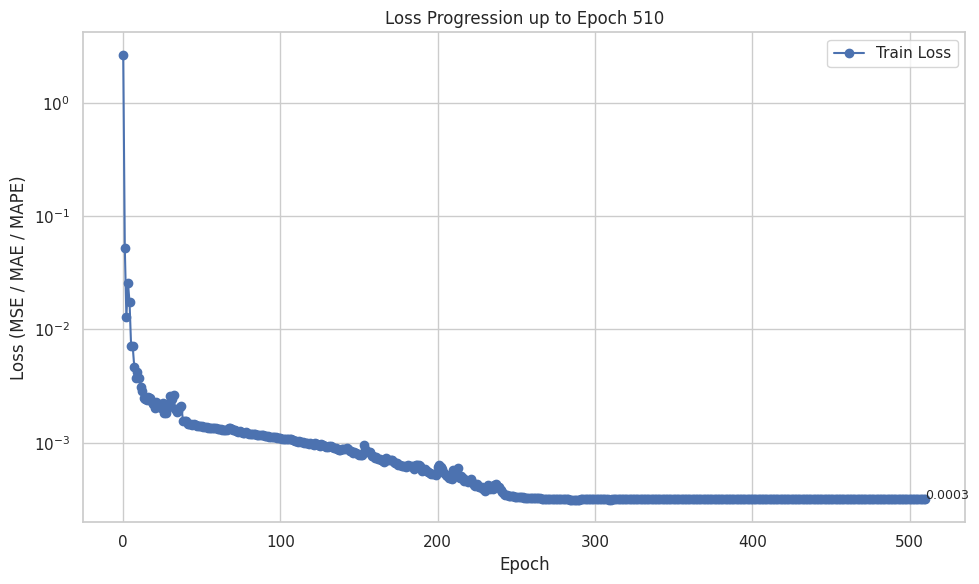

In [14]:
progression_plot(epoch_history, train_loss_history, log_scale=True)
plt.savefig("nbeats_loss_curve.png")
plt.show()

# Model Evaluation

In [15]:
model.eval()

current_data = data_test_scaled[-7:]['y'].values
preds, trend_preds, season_preds = [], [], []

with torch.inference_mode():
  for i in tqdm(range(31)):
    input_feat = torch.tensor(
        current_data,
        dtype=torch.float32,
        device=device
        ).unsqueeze(0).unsqueeze(-1)

    outputs = model(input_feat)
    preds.append(outputs["forecast_total"].detach().cpu().numpy().ravel()[0])
    trend_preds.append(outputs["forecast_trend"].detach().cpu().numpy().ravel()[0])
    season_preds.append(outputs["forecast_seasonality"].detach().cpu().numpy().ravel()[0])

    current_data = np.append(current_data[1:], outputs["forecast_total"].detach().cpu().numpy().ravel()[0])

100%|██████████| 31/31 [00:00<00:00, 1210.94it/s]


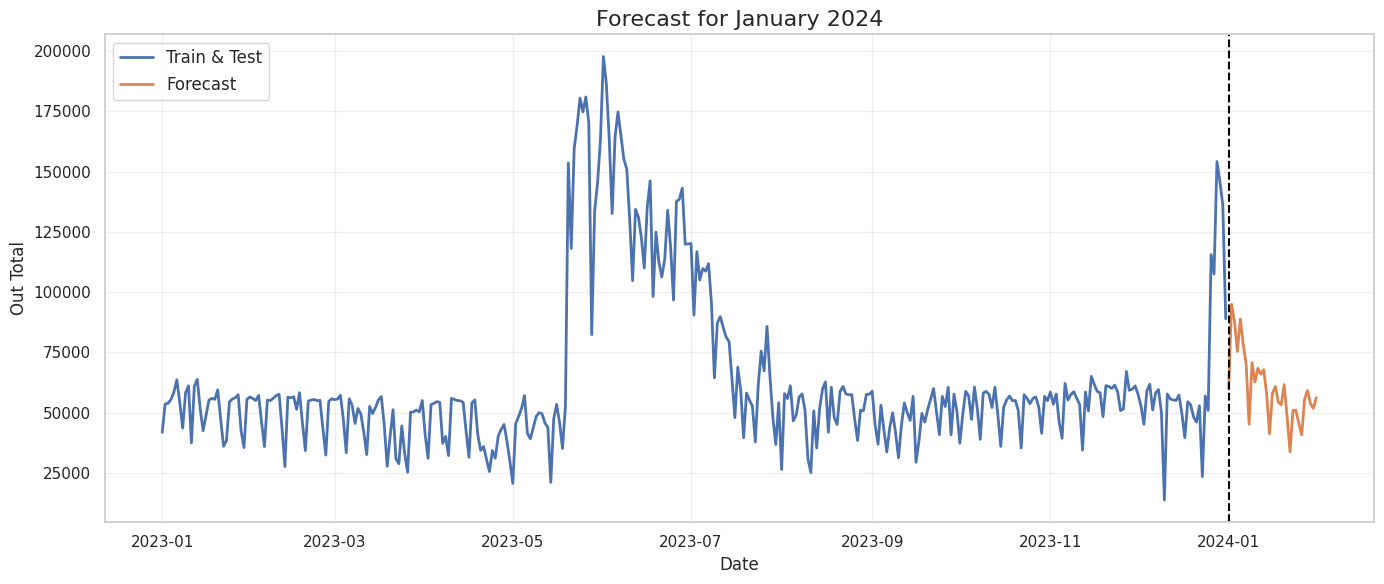

In [16]:
forecast_data = pd.DataFrame(scaler.inverse_transform(np.array(preds).reshape(-1, 1)).ravel(),
                             columns=['y'],
                             index=pd.date_range(start='2024-01-01', end='2024-01-31', freq='D'))

plt.figure(figsize=(14, 6))

# Plot
plt.plot(pd.concat([data, data_test])['y'], label='Train & Test', linewidth=2)
plt.plot(forecast_data['y'], label='Forecast', linewidth=2)

plt.axvline(forecast_data.index.min(), color='black', linestyle='--', linewidth=1.5)

plt.title('Forecast for January 2024', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Out Total', fontsize=12)

plt.grid(alpha=0.3)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

## Train vs. Prediction

In [17]:
train_pred, train_trend, train_season = forecast_with_rolling_origin(model, data_scaled[:31], data_scaled[31:], 7, device)

train_pred = scaler.inverse_transform(train_pred.reshape(-1, 1)).ravel()
train_trend = scaler.inverse_transform(train_trend.reshape(-1, 1)).ravel()
train_season = scaler.inverse_transform(train_season.reshape(-1, 1)).ravel()

train_pred = pd.DataFrame(train_pred, columns=['y'], index=data[31:].index)
train_trend = pd.DataFrame(train_trend, columns=['y'], index=data[31:].index)
train_season = pd.DataFrame(train_season, columns=['y'], index=data[31:].index)

100%|██████████| 303/303 [00:00<00:00, 797.20it/s]


In [18]:
print(f"""
  MAPE: {mean_absolute_percentage_error(data.iloc[31:, 0], train_pred['y'])}
  MASE: {mean_absolute_scaled_error(data.iloc[31:, 0], train_pred['y'])}
  WAPE: {weighted_absolute_percentage_error(data.iloc[31:, 0], train_pred['y'])}
""")


  MAPE: 0.0631018802523613
  MASE: 0.2781176814639828
  WAPE: 4.634670626936156



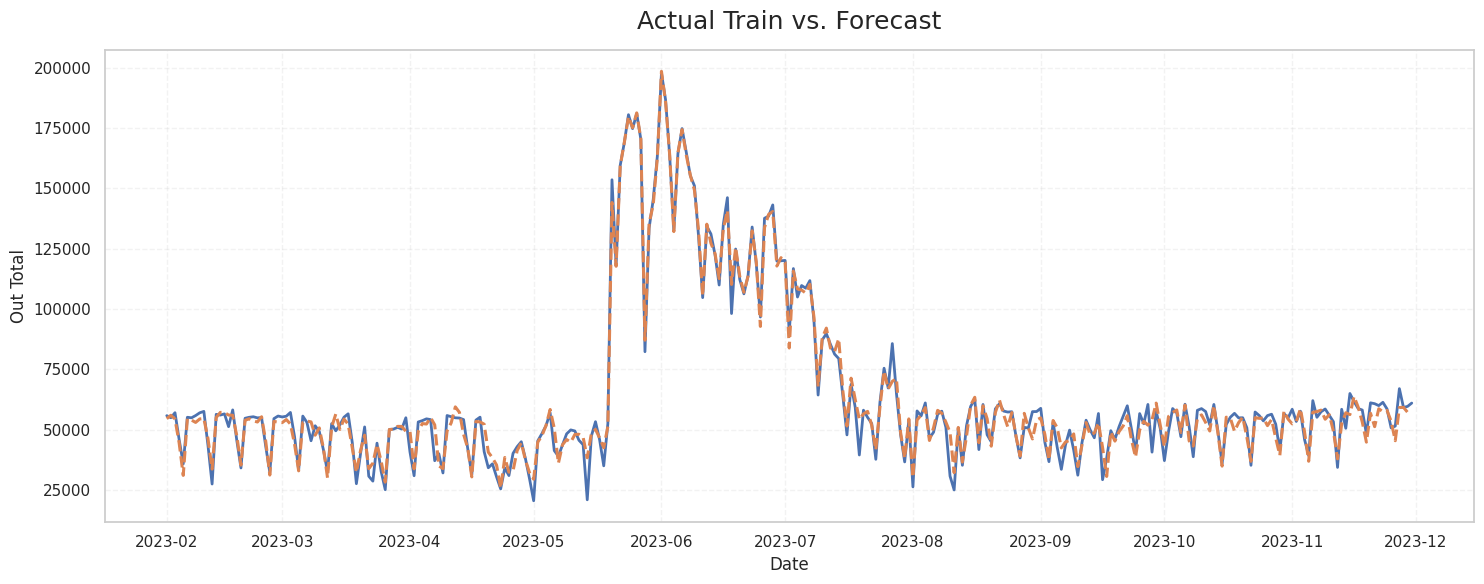

In [19]:
plt.figure(figsize=(15, 6))

plt.plot(data.iloc[31:, 0], linewidth=2)
plt.plot(train_pred['y'], linewidth=2.2, linestyle='--')

# Title & Labels
plt.title('Actual Train vs. Forecast', fontsize=18, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Out Total', fontsize=12)

plt.grid(alpha=0.25, linestyle='--')

plt.tight_layout()
plt.show()

## Test vs. Prediction

In [20]:
test_pred, test_trend, test_season = forecast_with_rolling_origin_with_fine_tune(model, model.state_dict(), criterion, data_scaled, data_test_scaled, 7, device)

test_pred = scaler.inverse_transform(test_pred.reshape(-1, 1)).ravel()
test_trend = scaler.inverse_transform(test_trend.reshape(-1, 1)).ravel()
test_season = scaler.inverse_transform(test_season.reshape(-1, 1)).ravel()

test_pred = pd.DataFrame(test_pred, columns=['y'], index=data_test.index)
test_trend = pd.DataFrame(test_trend, columns=['y'], index=data_test.index)
test_season = pd.DataFrame(test_season, columns=['y'], index=data_test.index)

Train:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)

Train: 100%|██████████| 6/6 [00:00<00:00, 30.81it/s]
                                                    
Train: 100%|██████████| 6/6 [00:00<00:00, 31.70it/s]
                                                    
Train:  33%|███▎      | 2/6 [00:00<00:00, 17.41it/s]
                                                    
Train:  33%|███▎      | 2/6 [00:00<00:00, 16.22it/s]
                                                    
Train:  33%|███▎      | 2/6 [00:00<00:00, 15.82it/s]
                                                    
Train:  33%|███▎      | 2/6 [00:00<00:00, 16.70it/s]
                                                    
Train: 100%|██████████| 6/6 [00:00<00:00, 31.74it/s]
                                            

In [21]:
print(f"""
  MAPE: {mean_absolute_percentage_error(data_test['y'], test_pred['y'])}
  MASE: {mean_absolute_scaled_error(data_test['y'], test_pred['y'])}
  WAPE: {weighted_absolute_percentage_error(data_test['y'], test_pred['y'])}
""")


  MAPE: 0.21552056074142456
  MASE: 0.7489222961802503
  WAPE: 17.093553185865225



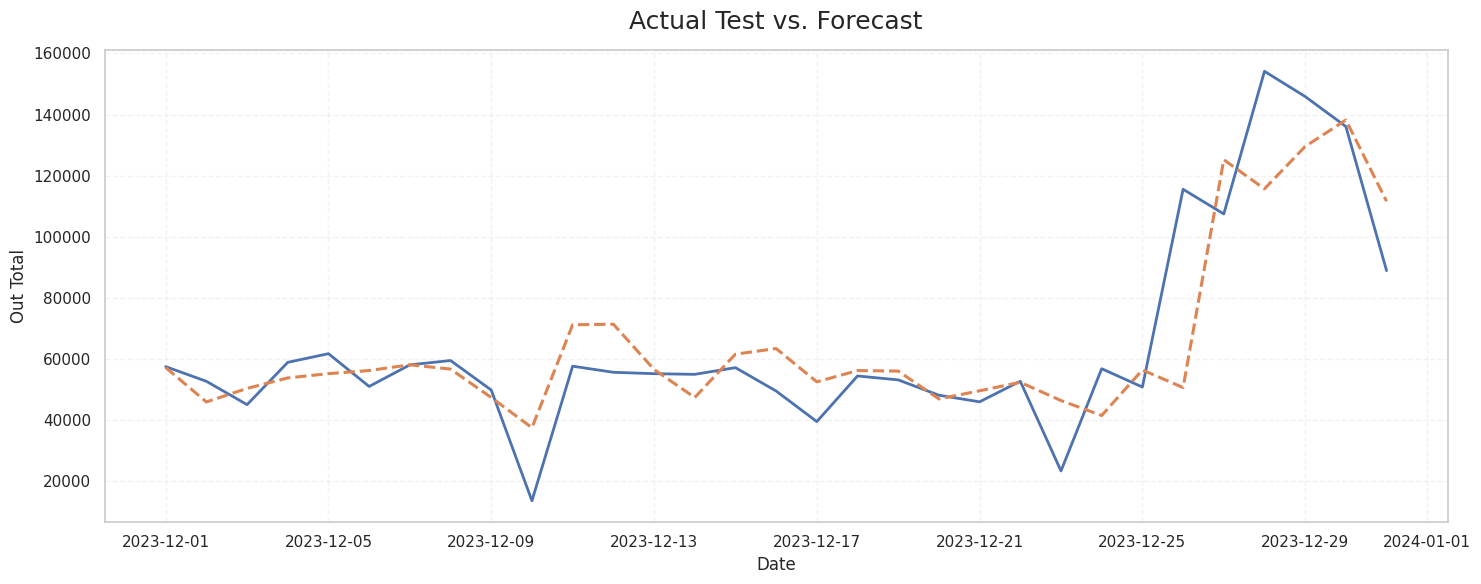

In [22]:
plt.figure(figsize=(15, 6))

plt.plot(data_test['y'], linewidth=2)
plt.plot(test_pred['y'], linewidth=2.2, linestyle='--')

# Title & Labels
plt.title('Actual Test vs. Forecast', fontsize=18, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Out Total', fontsize=12)

plt.grid(alpha=0.25, linestyle='--')

plt.tight_layout()
plt.show()

# Model Interpretation

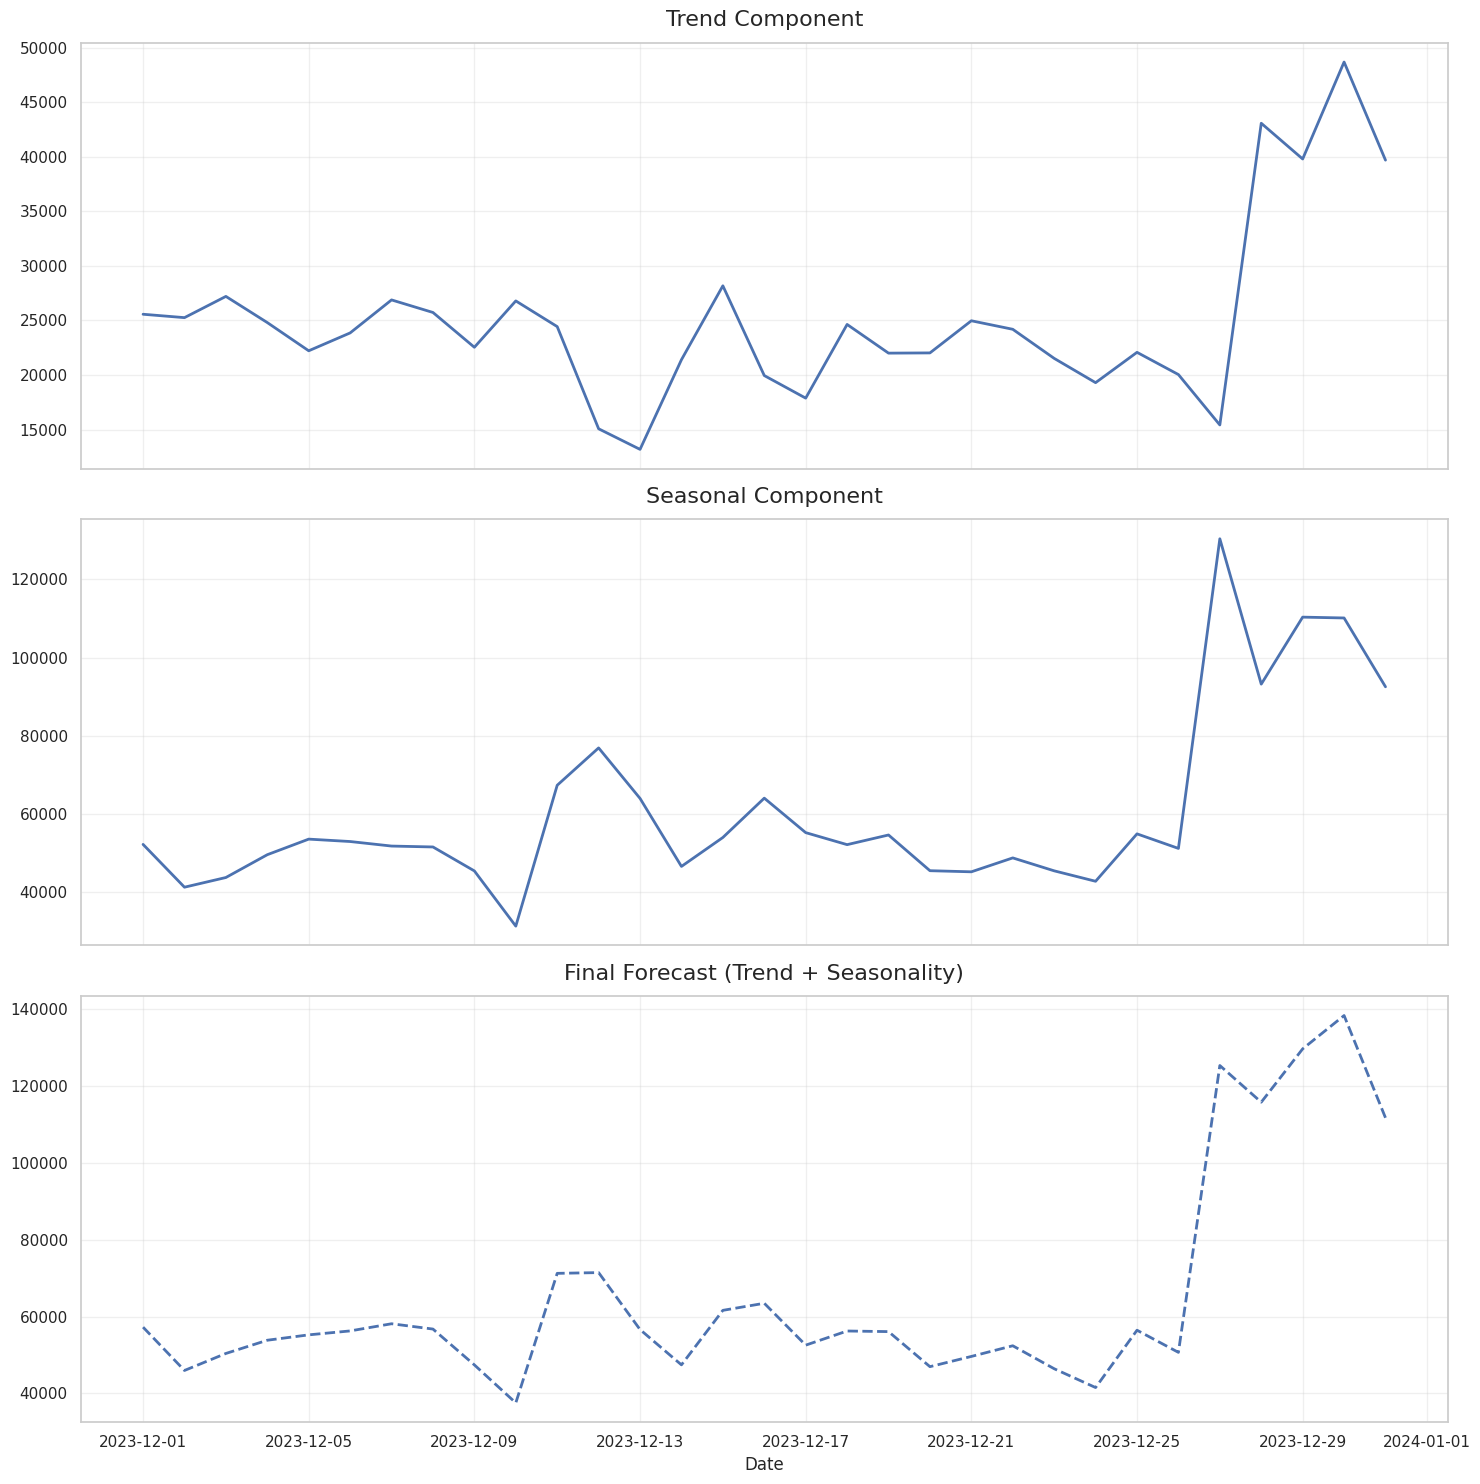

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

# Trend Component
axs[0].plot(test_trend['y'], linewidth=2)
axs[0].set_title('Trend Component', fontsize=16, pad=12)
axs[0].grid(alpha=0.3)

# Seasonal Component
axs[1].plot(test_season['y'], linewidth=2)
axs[1].set_title('Seasonal Component', fontsize=16, pad=12)
axs[1].grid(alpha=0.3)

# Final Forecast
axs[2].plot(test_pred['y'], linewidth=2, linestyle='--')
axs[2].set_title('Final Forecast (Trend + Seasonality)', fontsize=16, pad=12)
axs[2].grid(alpha=0.3)

plt.xlabel('Date', fontsize=12)

plt.tight_layout()
plt.show()
